# Bias model bootstrapping notebook

Eventually this notebook will (hopefully?) contain all the code necessary to run our final experiments.
For now it just contains a demo of MCE IRL on some gridworlds from the "learning biases" paper.

First we have some not-very-interesting setup:

In [1]:
%matplotlib inline

# These are useful for debugging, but make code slower:
%load_ext autoreload
%autoreload 2

import logging

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import jax
import jax.experimental.optimizers as jopt
import jax.random as jrandom
import numpy as np

from pref_bootstrap.envs import gridworld, mdp_interface
from pref_bootstrap.algos import mce_irl
import pref_bootstrap.feedback_learner_blind_irl as fbl_blind_irl
import pref_bootstrap.feedback_learner_paired_comparisons as fbl_paired_comp
import pref_bootstrap.reward_models as r_models
import pref_bootstrap.expert_base as experts

sns.set(context='notebook', style='darkgrid')
logging.basicConfig(level=logging.INFO)
np.set_printoptions(precision=4, linewidth=100)

## Very simple example of using environments and MCE IRL code

This code doesn't use the new agent API

In [2]:
random_gridworld = gridworld.GridworldMdp.generate_random(4, 4, 0.2, 0.1)
env = mdp_interface.GridworldEnvWrapper(random_gridworld, random_gridworld.height + random_gridworld.width)

In [3]:
# generate some optimal demos (represented by a single optimal occupancy measure vector) and run MCE IRL
_, optimal_om = mce_irl.mce_occupancy_measures(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
opt_tup = jopt.momentum(1e-2, 0.9)

In [4]:
rew_params, visitations = mce_irl.mce_irl(env, opt_tup, rmodel, optimal_om, print_interval=100, max_iter=1000)

INFO:root:Occupancy measure error@iter   0: 3.897072 (||params||=4.426958, ||grad||=4.619287, ||E[dr/dw]||=4.229805)
INFO:root:Occupancy measure error@iter  100: 0.035523 (||params||=5.612111, ||grad||=0.043558, ||E[dr/dw]||=7.038505)
INFO:root:Occupancy measure error@iter  200: 0.022524 (||params||=5.846158, ||grad||=0.027612, ||E[dr/dw]||=7.050268)
INFO:root:Occupancy measure error@iter  300: 0.016561 (||params||=6.011077, ||grad||=0.020298, ||E[dr/dw]||=7.055675)
INFO:root:Occupancy measure error@iter  400: 0.013108 (||params||=6.139563, ||grad||=0.016064, ||E[dr/dw]||=7.058811)
INFO:root:Occupancy measure error@iter  500: 0.010849 (||params||=6.245176, ||grad||=0.013294, ||E[dr/dw]||=7.060864)
INFO:root:Occupancy measure error@iter  600: 0.009253 (||params||=6.334990, ||grad||=0.011337, ||E[dr/dw]||=7.062316)
INFO:root:Occupancy measure error@iter  700: 0.008063 (||params||=6.413187, ||grad||=0.009879, ||E[dr/dw]||=7.063398)
INFO:root:Occupancy measure error@iter  800: 0.007143 (||

In [5]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))
print('\nRecovered state visitation frequencies for each grid cell:')
print(visitations.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.3665e-07 1.0978e-04 0.0000e+00]
 [0.0000e+00 1.0002e+00 6.9997e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]

Recovered state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.1770e-05 2.8039e-03 0.0000e+00]
 [0.0000e+00 1.0033e+00 6.9938e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


## More complex example showing how to use an EnvFeedbackModel to recover both a reward function + sub-rationality model

This code actually does use the new API to show how to use the 'blind IRL' feedback model (& its associated expert, which doesn't support observation blinding yet).

In [6]:
irl_feedback_model = fbl_blind_irl.BlindIRLFeedbackModel(env)
rmodel = r_models.LinearRewardModel(env.obs_dim)
rng = jrandom.PRNGKey(42)
irl_bias_params, rng = irl_feedback_model.init_bias_params(rng)
irl_expert = experts.MEDemonstratorExpert(env, np.random.randint((1 << 31) - 1))
# we'll do IRL based on 10 trajectories
irl_dataset = irl_expert.interact(10)

In [7]:
print('Log likelihood (IRL):', float(irl_feedback_model.log_likelihood(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. reward params (IRL):\n', np.asarray(irl_feedback_model.log_likelihood_grad_rew(irl_dataset, rmodel, irl_bias_params)))
print('Gradient w.r.t. bias params (IRL):\n', irl_feedback_model.log_likelihood_grad_bias(irl_dataset, rmodel, irl_bias_params))

Log likelihood (IRL): -14.336145401000977
Gradient w.r.t. reward params (IRL):
 [ 0.      0.      0.      0.      0.     -0.0909 -0.0239  0.      0.     -0.0396  0.1225  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (IRL):
 [ 0.      0.      0.      0.      0.     -0.1049  0.0058  0.      0.     -0.1249 -0.0751  0.
  0.      0.      0.      0.    ]


## Another example with the paired comparison learner

In [8]:
pc_feedback_model = fbl_paired_comp.PairedCompFeedbackModel(env)
pc_bias_params, rng = pc_feedback_model.init_bias_params(rng)
pc_expert = experts.PairedComparisonExpert(env, boltz_temp=1.0, seed=42)

# generate some random trajectories & compare a random subset of them
def generate_comparison_dataset(pc_ntraj):
    pc_trajectories = mce_irl.mce_irl_sample(env, pc_ntraj, R=np.ones((env.n_states, )))
    to_compare_first = np.arange(len(pc_trajectories['states']))
    comparisons = []
    for first_idx in range(pc_ntraj):
        second_idx = np.random.randint(pc_ntraj - 1)
        if second_idx >= first_idx:
            second_idx += 1
        traj1_is_better = pc_expert.interact(
            dict(states=pc_trajectories['states'][first_idx]),
            dict(states=pc_trajectories['states'][second_idx]))
        if traj1_is_better:
            # the better trajectory comes before the worse one
            comparisons.append((first_idx, second_idx))
        else:
            comparisons.append((second_idx, first_idx))
    return {
        'trajectories': pc_trajectories,
        'comparisons': np.asarray(comparisons),
    }

comparison_dataset = generate_comparison_dataset(10)

In [9]:
print('Log likelihood (PC):', float(pc_feedback_model.log_likelihood(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. reward params (PC):\n', np.asarray(pc_feedback_model.log_likelihood_grad_rew(comparison_dataset, rmodel, pc_bias_params)))
print('Gradient w.r.t. bias params (PC):\n', pc_feedback_model.log_likelihood_grad_bias(comparison_dataset, rmodel, pc_bias_params))

Log likelihood (PC): -1.3823356628417969
Gradient w.r.t. reward params (PC):
 [ 0.      0.      0.      0.      0.     -0.3065  0.3023  0.      0.     -0.7002  0.7044  0.
  0.      0.      0.      0.    ]
Gradient w.r.t. bias params (PC):
 -2.1268325


In [10]:
# ALRIGHT, HERE IS WHERE I WILL DEBUG THE TOPK FEEDBACK LEARNER
# ABLATIONS: COULD WE DO BETTER IF ALL OUR TRAJECTORIES ARE GOOD? 
# OR IS IT NECESSARY TO HAVE BAD TRAJECTORIES? 

In [37]:
import pref_bootstrap.feedback_learner_topk as fbl_topk

rmodel = r_models.LinearRewardModel(env.obs_dim)
top_K_feedback_model = fbl_topk.TopKFeedbackModel(env)
top_K_expert = experts.TopKExpert(env, temp=.3, K=.05, seed=42)

In [38]:
# def genereate_top_K_dataset(n_traj): 
import random

n_traj = 1000
traj = mce_irl.mce_irl_sample(env, n_traj, R=np.ones((env.n_states,)))
labels= top_K_expert.interact(traj)

labels_final, traj_final = [], []
for l, t in zip(labels, traj['states']): 
    if not(l):
        if random.random() < (np.sum(labels)/len(labels)):
            labels_final.append(l), traj_final.append(t)
    else: 
        labels_final.append(l), traj_final.append(t)
        
labels_final = np.array(labels_final)
        
print(np.sum(labels)/len(labels))
print(np.sum(labels_final)/len(labels_final))


cutoff 54.0
21.0 False
12.0 False
24.0 False
36.0 False
12.0 False
15.0 False
18.0 False
9.0 False
9.0 False
30.0 False
9.0 False
21.0 False
36.0 False
36.0 False
12.0 False
9.0 False
6.0 False
18.0 False
33.0 False
39.0 False
21.0 False
12.0 False
15.0 False
12.0 False
9.0 False
12.0 False
18.0 False
18.0 False
9.0 False
21.0 False
18.0 False
15.0 False
9.0 False
39.0 True
21.0 False
36.0 False
24.0 False
63.0 True
12.0 False
12.0 False
36.0 False
30.0 False
15.0 False
15.0 False
12.0 False
45.0 False
21.0 False
18.0 False
6.0 False
9.0 False
15.0 False
36.0 False
33.0 False
9.0 False
18.0 False
6.0 False
6.0 False
12.0 False
12.0 False
18.0 False
27.0 False
21.0 False
15.0 False
12.0 False
9.0 False
3.0 False
0.0 False
27.0 False
9.0 False
30.0 False
39.0 False
54.0 True
30.0 False
24.0 False
21.0 False
21.0 False
27.0 False
9.0 False
18.0 False
30.0 False
21.0 False
33.0 False
45.0 False
27.0 False
27.0 False
15.0 False
33.0 False
36.0 False
18.0 False
27.0 False
15.0 False
24.0 Fal

In [28]:
params = {}
from jax import random as jrnd
import jax.numpy as jnp
from jax import grad, value_and_grad
key = jrnd.PRNGKey(0)
key, wkey = jrnd.split(key, 2)
params['reward_est'] = jrnd.normal(wkey, (env.n_states,))
params['bias'] = jnp.ones((1,))
# params['temperature'] = .5*jnp.ones((1, ))
lr = 1e-3
steps = 10000
loss_prev = float('Inf')
delta = 100
eps = 1e-4

step = 0
while(np.abs(delta) > eps and step<steps):
    loss, gradients = (value_and_grad(top_K_feedback_model.loss)(params, np.array(traj_final), (labels_final)))
    if step % 100 == 0:
        print('step %d loss %.3f' %(step, loss))
        print(params['bias'])
    if step > 0: 
        delta = loss-loss_prev
   
    for k in params.keys(): 
        params[k] -= lr*gradients[k]
        
    loss_prev = loss
    step +=1
    
if np.abs(delta) <= .0001: 
    print('terminated due to delta')
else: 
    print('terminated due to steps exceeding %d' %steps)


step 0 loss 0.690
[1.]
step 100 loss 0.361
[0.9736]
step 200 loss 0.247
[0.9581]
step 300 loss 0.200
[0.9484]
step 400 loss 0.176
[0.9419]
terminated due to delta


In [29]:
np.array(params['reward_est'])

array([ 0.2082, -1.058 , -0.2937, -0.4412,  0.2367, -0.0441, -0.9414,  1.156 , -0.5381, -0.3953,
        0.6653, -1.4129,  1.8543,  0.2276,  0.4975, -2.0897], dtype=float32)

Text(0.5,1,'Estimated Reward Function')

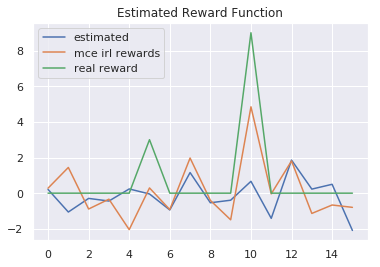

In [30]:
plt.plot(params['reward_est'], label='estimated')
plt.plot(rew_params, label='mce irl rewards')
plt.plot(env.reward_matrix, label='real reward')
plt.legend()
plt.title('Estimated Reward Function')

In [31]:
_, topk_om = mce_irl.mce_occupancy_measures(env, R=params['reward_est'])

In [32]:
print('Optimal state visitation frequencies for each grid cell:')
print(optimal_om.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 1.3665e-07 1.0978e-04 0.0000e+00]
 [0.0000e+00 1.0002e+00 6.9997e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00]]


In [33]:
print('Inferred w. Top K')
print(topk_om.reshape((random_gridworld.height, random_gridworld.width)))

Inferred w. Top K
[[0.     0.     0.     0.    ]
 [0.     0.2822 0.225  0.    ]
 [0.     1.999  5.4938 0.    ]
 [0.     0.     0.     0.    ]]


In [34]:
print('Optimal state visitation frequencies for each grid cell:')
print(env.reward_matrix.reshape((random_gridworld.height, random_gridworld.width)))

Optimal state visitation frequencies for each grid cell:
[[0. 0. 0. 0.]
 [0. 3. 0. 0.]
 [0. 0. 9. 0.]
 [0. 0. 0. 0.]]


In [35]:
params

{'reward_est': DeviceArray([ 0.2082, -1.058 , -0.2937, -0.4412,  0.2367, -0.0441, -0.9414,  1.156 , -0.5381,
              -0.3953,  0.6653, -1.4129,  1.8543,  0.2276,  0.4975, -2.0897], dtype=float32),
 'bias': DeviceArray([0.9376], dtype=float32)}

/userdata/smetzger/gim/lib/python3.6/site-packages/jax/_src/lax/lax.py:6271: UserWarning: Explicitly requested dtype <class 'float'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


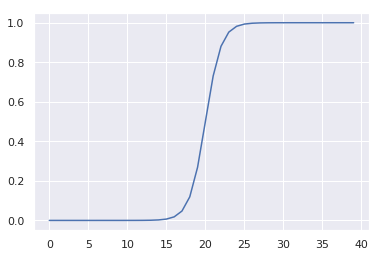

In [36]:
plt.plot(jax.nn.sigmoid(jnp.arange(40).astype(float) -20) > random.random)